### Установим нужные библиотеки

In [4]:
!pip install pandas 
!pip install matplotlib 
!pip install plotly 
!pip install open3d 
!pip install laspy[lazrs,laszip]
!pip install kiss-icp[all]

In [5]:
import copy, sys, os, time
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import open3d as o3d
import laspy

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Попробуем отрисовать 3D сцену

In [6]:
pc_path = '.'
pc_fn = 'new.002.001.robosenseCapture_36182.laz'
pc1 = laspy.read(os.path.join(pc_path, pc_fn))

In [7]:
xyz = np.vstack((pc1.x, pc1.y, pc1.z)).transpose()
xyz.shape # 57600 точек

(57600, 3)

In [8]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
print('pcd:', pcd)

pcd: PointCloud with 57600 points.


In [9]:
o3d.visualization.draw_geometries([pcd])

Имеются явные шумы желтые и красные точни, можно попытаться их отчистить

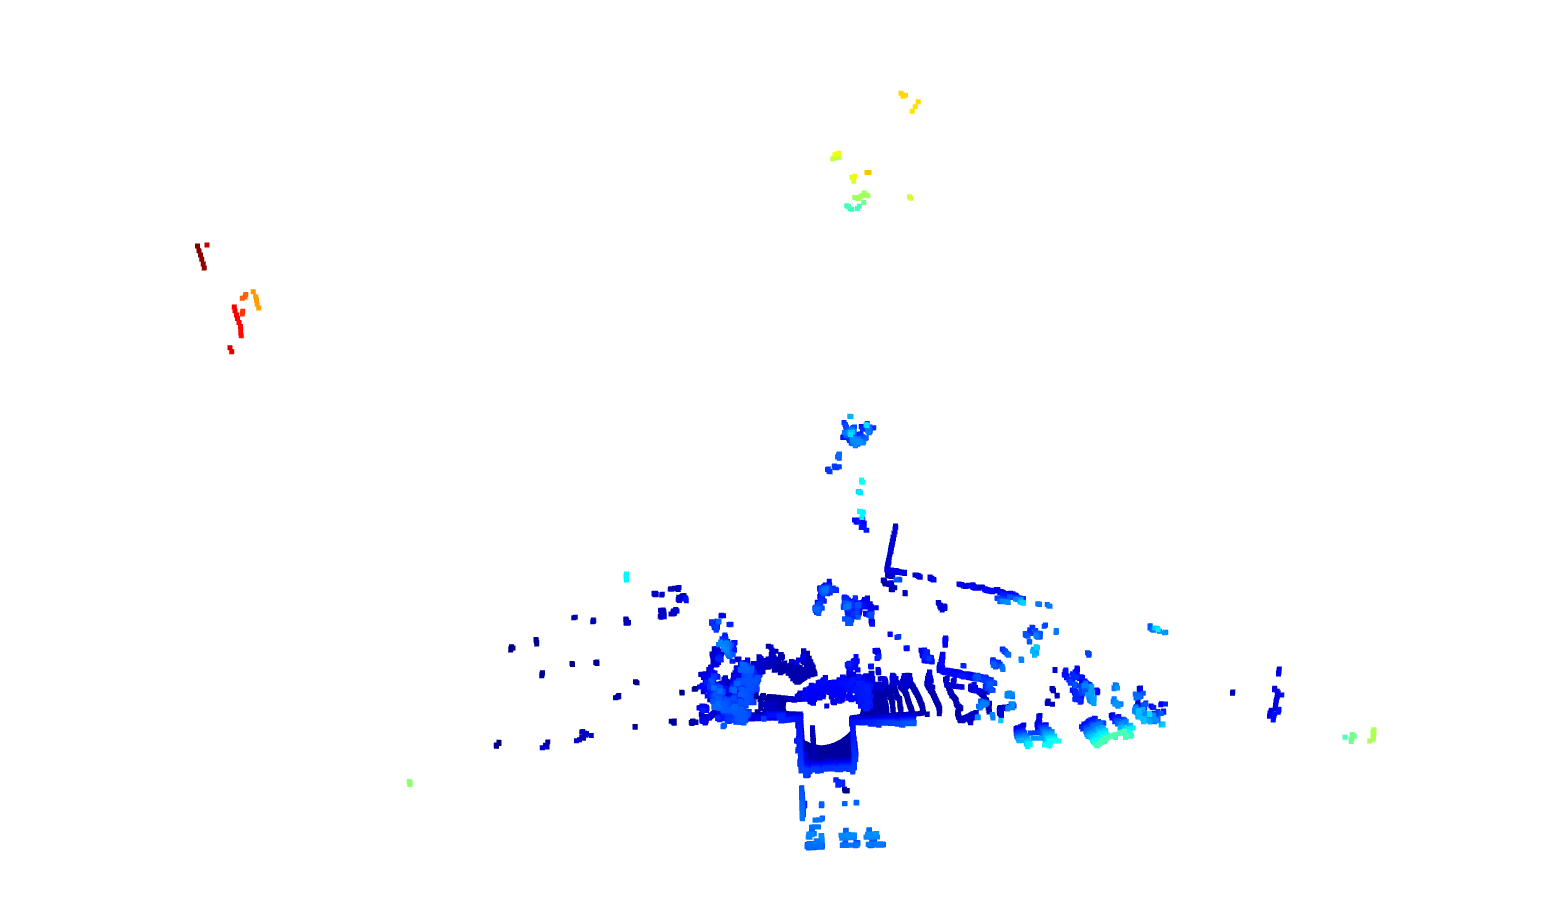

In [10]:
xyz_сlear = np.vstack((pc1.x, pc1.y, pc1.z)).transpose()
xyz_сlear.shape # 57600 точек

(57600, 3)

In [11]:
df = pd.DataFrame(xyz_сlear, columns = ['x', 'y', 'z']) # Прошу меня простить за pandas)
df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2) # Добавим расстояние от центра координат
perc = np.percentile(df['r'], 95)
df = df[df['r'] < perc]
df = df.iloc[:,:-1] # Удалим все точки дальше чем 95 процентиль чтобы избавится от шумов

In [12]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(df.values)
print('pcd:', pcd)
o3d.visualization.draw_geometries([pcd])

pcd: PointCloud with 54720 points.


### Выглаядит сильно лучше
Можно различить здания и машину)

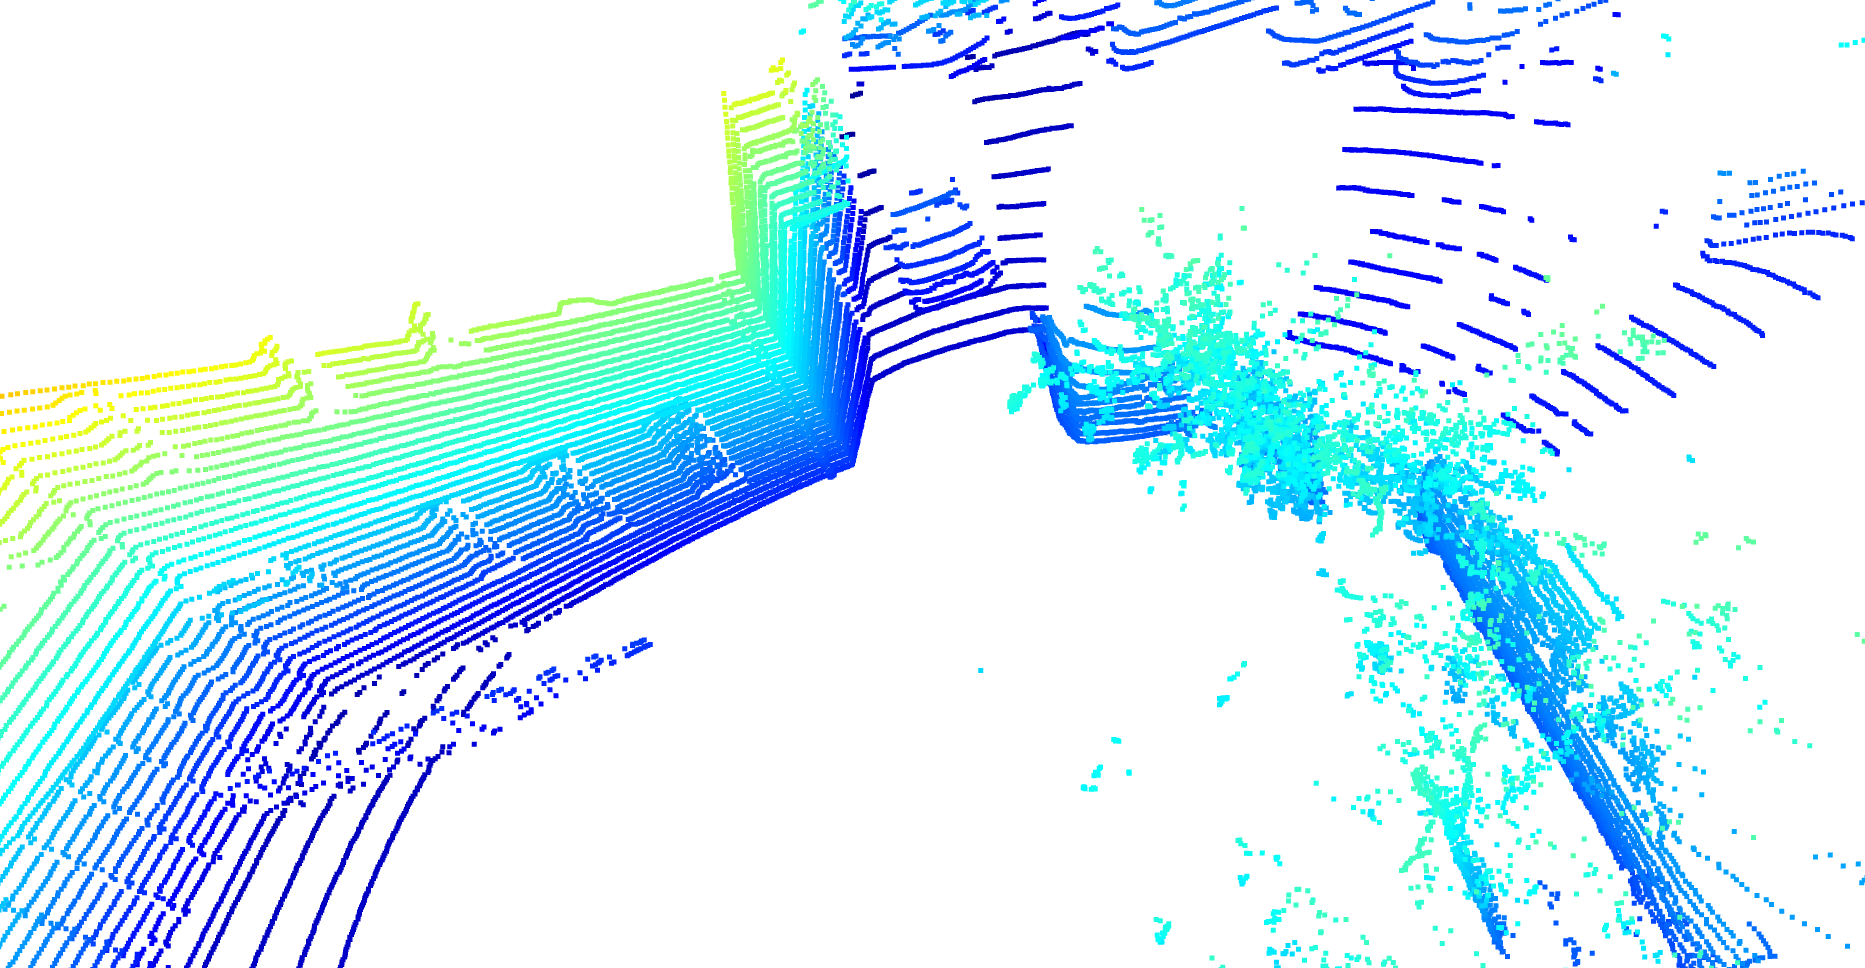

In [13]:
# Оберенем отчистку сцены в функцию
def clear_scene(scene, perc = 95):
    df = pd.DataFrame(scene, columns = ['x', 'y', 'z']) # Прошу меня простить за pandas)
    df['r'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2) # Добавим расстояние от центра координат
    perc = np.percentile(df['r'], perc)
    df = df[df['r'] < perc]
    df = df.iloc[:,:-1] # Удалим все точки дальше чем 95 процентиль чтобы избавится от шумов
    return df.values

#### Работа с множеством сцен и визуализация

In [15]:
%%time
# Загрузим все измерения из папки data
points = []
pc_path = './data'

files_list = os.listdir(pc_path)

files_list.sort()

for file in files_list:
    pc = laspy.read(os.path.join(pc_path, file))
    xyz = np.vstack((pc.x, pc.y, pc.z)).transpose()
    xyz = clear_scene(xyz)
    points.append(xyz)

CPU times: user 12 s, sys: 198 ms, total: 12.2 s
Wall time: 10.7 s


In [16]:
#Функция для анимации измерений
def data_viz(scene_points, fps=20):
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # geometry is the point cloud used in your animaiton
    geometry = o3d.geometry.PointCloud()
    geometry.points = o3d.utility.Vector3dVector(scene_points[0])
    vis.add_geometry(geometry)

    for i in range(len(scene_points)):
        # now modify the points of your geometry
        # you can use whatever method suits you best, this is just an example
        geometry.points = o3d.utility.Vector3dVector(scene_points[i])
        vis.update_geometry(geometry)
        vis.poll_events()
        vis.update_renderer()
        time.sleep(1/fps)
    vis.close()

In [17]:
data_viz(points[:100])

#### Модуль kiss-icp очень капризный к формату данных сконвертируем все в сырой .xyz

In [31]:
%%time
pc_path = './data'
pc_path_out = './data2'

for file in os.listdir(pc_path):
    pc = laspy.read(os.path.join(pc_path, file))
    xyz = np.vstack((pc.x, pc.y, pc.z)).transpose()
    xyz = clear_scene(xyz)
    np.savetxt(os.path.join(pc_path_out, file[:-4] + '.xyz'), xyz)

CPU times: user 1min 25s, sys: 1.72 s, total: 1min 27s
Wall time: 1min 25s


In [1]:
# Рассчет матриц перехода для свех наших измерений
!kiss_icp_pipeline ./data2 

Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required
100%|████████████████████████████████████| 501/501 [00:47<00:00, 10.44 frames/s]
[WARNING] No GT poses available, skipping evaluation


In [2]:
# Рассчет матриц перехода для свех наших измерений с визуализацией
!kiss_icp_pipeline ./data2 --visualize

Trying to guess how to read your data: `pip install "kiss-icp[all]"` is required
RegistrationVisualizer initialized. Press:
	[SPACE] to pause/start
	  [ESC] to exit
	    [N] to step
	    [F] to toggle on/off the input cloud to the pipeline
	    [K] to toggle on/off the subsbampled frame
	    [M] to toggle on/off the local map
	    [V] to toggle ego/global viewpoint
	    [T] to toggle the trajectory view(only available in global view)
	    [C] to center the viewpoint
	    [W] to toggle a white background
	    [B] to toggle a black background

100%|████████████████████████████████████| 501/501 [00:55<00:00,  8.96 frames/s]
[WARNING] No GT poses available, skipping evaluation


In [18]:
poses = np.load('./results/2023-10-21_10-28-05/data2_poses.npy') # Матрицы перехода для однородных координат


In [15]:
points_uni = []       # Переход к однородным координанам
col_len = np.ones(points[0].shape[0])
for points_el in points:
    points_uni.append(np.c_[points_el, col_len])

In [19]:
%%time
# Перемножнение всех точек изменения на матрицу пехехода TODO: ОООЧЕНЬ ДОЛГО, переписать на векторизованные функциии
points_poses_uni = []
for i in range(len(points_uni)):
    tmp = np.ndarray((0,4))
    for j in points_uni[i]:
        tmp = np.append(tmp,[np.dot(poses[i], j)], axis = 0)
    points_poses_uni.append(tmp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
# Обрантый переход в координаты (x,y,z)
points_poses = []
for i in range(len(points_poses_uni)):
    points_poses.append(points_poses_uni[i][:, :-1] * np.column_stack((points_poses_uni[i][:, -1] ,points_poses_uni[i][:, -1] , points_poses_uni[i][:, -1] )))

In [21]:
# Объединям все сцены в одну и визуализируем)
point_cloud = np.array(points_poses[0])

for i in  points_poses:
    point_cloud = np.append(point_cloud, i, axis=0)

point_cloud.shape

(27469440, 3)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud)
print('pcd:', pcd)
o3d.visualization.draw_geometries([pcd])